In [28]:
#!/usr/bin/env python
# coding: utf-8

# Importeer de benodigde bibliotheken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from geopy.geocoders import GoogleV3
import geopandas as gpd
import folium
from folium import plugins

### faillissement_database_2023

In [31]:
# Lees de data uit de Excel-bestanden
data = pd.read_excel('faillissement_database_2023.xlsx')

# Maak de data schoon en voorbewerk deze
data['ORG_PLAATS'] = data['ORG_PLAATS'].str.strip()
data['Activiteit'] = data['Activiteit'].str.strip()
data['Uitspraak'] = data['Uitspraak'].str.strip()
data['Status_faillissement'] = data['Status_faillissement'].str.strip()

data['ORG_KVK'] = pd.to_numeric(data['ORG_KVK'], errors='coerce', downcast='integer').fillna(0).astype(int)
data['Sbi-code'] = pd.to_numeric(data['Sbi-code'], errors='coerce', downcast='integer').fillna(0).astype(int)
data = data.drop_duplicates(keep='first').reset_index(drop=True)

In [32]:
data.shape

(5465, 8)

In [33]:
data.head()

,ORG_KVK,Datum,ORG_NAAM,ORG_PLAATS,Sbi-code,Activiteit,Uitspraak,Status_faillissement
0,72772956,2023-01-11 00:00:00,Sotiri,Den Haag,1,Dienstverl. akk,Uitspraak,Faillissement
1,4077684,2023-01-19 00:00:00,V.O.F. Bth Weg,Riel,1,Fokken en houde,Uitspraak,Faillissement
2,66254868,2023-01-25 00:00:00,Future Crops Coöperatief,Poeldijk,1,Teelt specerij-,Uitspraak,Faillissement
3,67637957,2023-03-01 00:00:00,Leostesta Holding B.V.,Honselersdijk,1,NaN,Uitspraak,Faillissement
4,61736104,2023-03-01 00:00:00,Kwekerij Flower Expert,De Kwakel,1,NaN,Uitspraak,Faillissement


### Histogram van de faillissementsstatus in oplopende volgorde

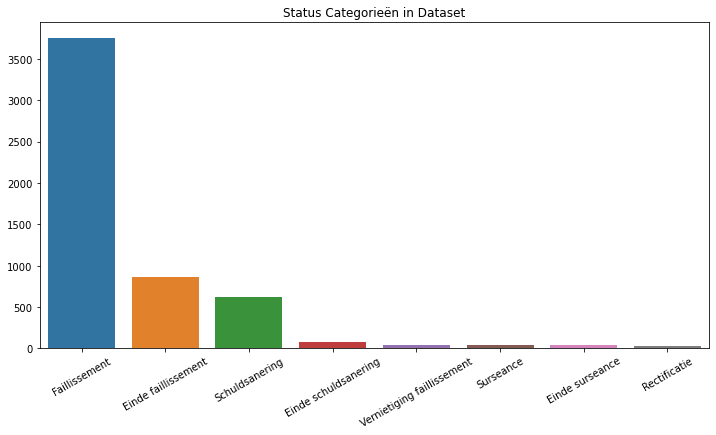

In [34]:
# Histogram van de faillissementsstatus in oplopende volgorde
plt.figure(figsize=(12, 6))
sns.countplot(x='Status_faillissement', data=data, order=data['Status_faillissement'].value_counts().index)
plt.xticks(rotation=30)
plt.title('Status Categorieën in Dataset')
plt.xlabel('')
plt.ylabel('')
plt.show()

### Histogram Aantal Faillissementen en Totaal per Maand

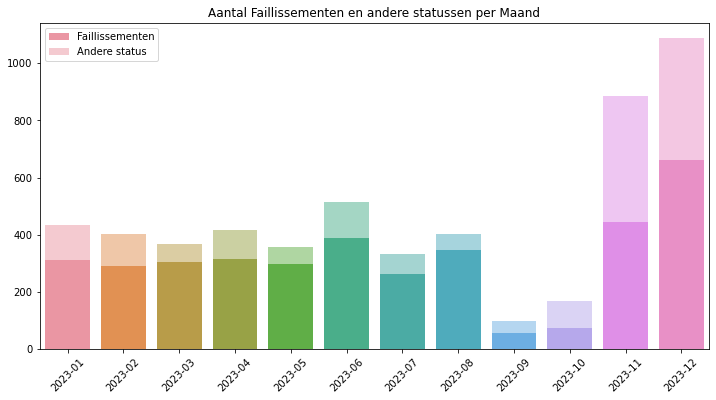

In [44]:
# Zorg ervoor dat de 'Datum' kolom een datetime formaat heeft
data['Datum'] = pd.to_datetime(data['Datum'])

# Voeg een kolom toe voor de maand
data['Maand'] = data['Datum'].dt.to_period('M')

# Groepeer de data per maand en tel het aantal faillissementen
maandelijkse_faillissementen = data[data['Status_faillissement'] == 'Faillissement'].groupby('Maand').size()

# Bereken het totaal aantal faillissementen per maand
totaal_per_maand = data.groupby('Maand').size()

# Maak een gecombineerde plot
plt.figure(figsize=(12, 6))
sns.barplot(x=maandelijkse_faillissementen.index.astype(str), y=maandelijkse_faillissementen.values, label='Faillissementen')
sns.barplot(x=totaal_per_maand.index.astype(str), y=totaal_per_maand.values, alpha=0.5, label='Andere status')
plt.xlabel('')
plt.ylabel('')
plt.title('Aantal Faillissementen en andere statussen per Maand')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### standaard bedrijfsindeling (Sbi) beschriving toevoegen

In [40]:
# Lees het Excel-bestand met de SBI-codes
sbi_data = pd.read_excel('standaard_bedrijfsindeling_2008_excel1.xlsx')

# Zet de 'Sbi-code'-kolom naar integers
sbi_data['Sbi-code'] = pd.to_numeric(sbi_data['Sbi-code'], errors='coerce').round().astype('Int64')

# Merge de 'data'-DataFrame met de SBI-informatie
merged_data = pd.merge(data, sbi_data, how='left', on='Sbi-code')

### Subset Faillissementen 2023

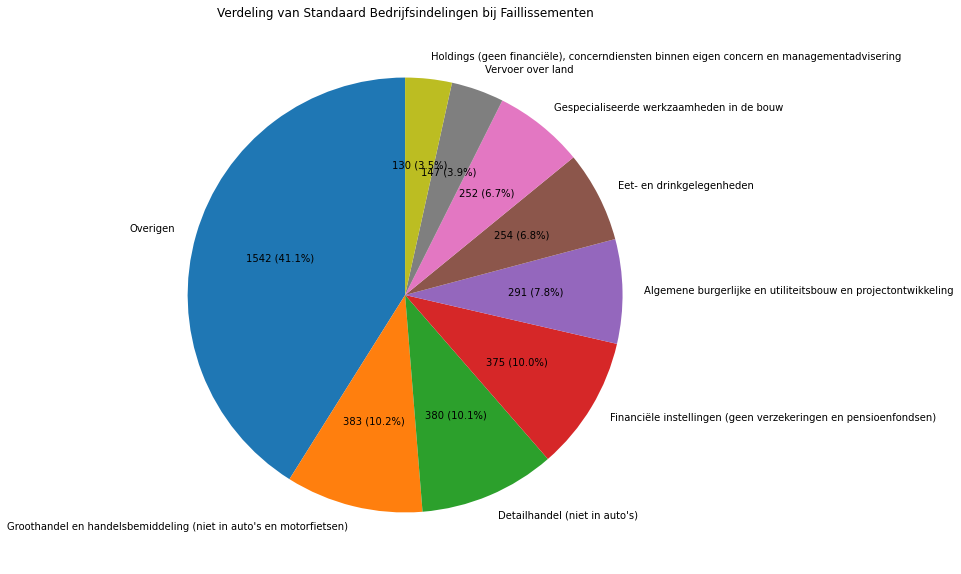

In [41]:
# Maak een subset met alleen 'faillissement' data
subset_faillissement = merged_data[merged_data['Status_faillissement'] == 'Faillissement'].copy()  # Maak een kopie om de SettingWithCopyWarning te vermijden

# Bereken de frequentie van elke SBI-code
sbi_counts = subset_faillissement['Standaard Bedrijfsindeling'].value_counts(normalize=True)

# Maak een nieuwe kolom 'Standaard Bedrijfsindeling_' en vul deze in met 'Overigen' waar de frequentie minder dan 3% is
subset_faillissement['Standaard Bedrijfsindeling_'] = subset_faillissement['Standaard Bedrijfsindeling'].apply(
    lambda x: 'Overigen' if sbi_counts.get(x, 0) < 0.03 else x
)

# Plot een taartdiagram van de verdeling van SBI-codes voor 'faillissement' data
plt.figure(figsize=(10, 10))
subset_faillissement['Standaard Bedrijfsindeling_'].value_counts().plot.pie(autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * len(subset_faillissement) / 100, p), startangle=90)
plt.title('Verdeling van Standaard Bedrijfsindelingen bij Faillissementen')
plt.ylabel('')  # Verwijder y-label om het overzicht te verbeteren
plt.show()

# Voeg 'ORG_PLAATS_1' kolom toe
subset_faillissement['ORG_PLAATS_1'] = subset_faillissement['ORG_PLAATS'] + ', The Netherlands'


# Vul lege waarden in de kolom 'Standaard Bedrijfsindeling_' met een lege string
subset_faillissement['Standaard Bedrijfsindeling_'] = subset_faillissement['Standaard Bedrijfsindeling_'].fillna('').astype(str)

# Voeg een nieuwe kolom 'icon_num' toe met waarde 1
subset_faillissement['icon_num'] = 1


### Geocoding met behulp van Google Maps API

In [ ]:
# Geocoding met behulp van Google Maps API
google_api_key = 'your_google_api_key'  # Vervang 'your_google_api_key' door je echte Google API-sleutel
geolocator = GoogleV3(api_key=google_api_key)

# Functie om coördinaten voor een stad te verkrijgen
def get_coordinates(city_name):
    location = geolocator.geocode(city_name)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

# Maak nieuwe 'Latitude' en 'Longitude' kolommen
subset_faillissement[['Latitude', 'Longitude']] = subset_faillissement['ORG_PLAATS_1'].apply(lambda x: pd.Series(get_coordinates(x)))

# Handmatige aanpassingen voor specifieke plaatsen
subset_faillissement.loc[subset_faillissement['ORG_PLAATS'] == 'Rijswijk', 'Latitude'] = 52.036751
subset_faillissement.loc[subset_faillissement['ORG_PLAATS'] == 'Rijswijk', 'Longitude'] = 4.325870

# Verwijder onjuiste locaties
subset_faillissement = subset_faillissement[~(subset_faillissement['ORG_PLAATS_1'] == 'Thailand, The Netherlands')]
subset_faillissement = subset_faillissement[~(subset_faillissement['ORG_PLAATS_1'] == 'Turkije, The Netherlands')]

In [ ]:
subset_faillissement.to_excel('subset_faillissement.xlsx')

## Geolocaties Faillissementen 2023 Folium map

In [ ]:
# Creëer een GeoDataFrame voor de geografische gegevens
gdf = gpd.GeoDataFrame(subset_faillissement, geometry=gpd.points_from_xy(subset_faillissement['Longitude'], subset_faillissement['Latitude']))

# Center de kaart op de gemiddelde coördinaten
mapa = folium.Map(location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()], tiles="CartoDB Positron", zoom_start=8)  # Verhoog het zoomniveau naar 10

# FeatureGroup voor 'ORG_PLAATS'
fg0 = folium.FeatureGroup(name='ORG_PLAATS', show=True)
marker_cluster0 = plugins.MarkerCluster().add_to(fg0)

# Voeg markers toe aan de cluster
for _, row in gdf.iterrows():
    # Pas de popup-informatie aan op basis van je datasetkolommen
    POPUP = folium.Popup(f"<b>ORG_NAAM:</b> {row['ORG_NAAM']}<br><b>Standaard Bedrijfsindeling:</b> {row['Standaard Bedrijfsindeling']}<br><b>Activiteit:</b> {row['Activiteit']}", max_width=600)

    folium.Marker(
        location=[row.geometry.centroid.y, row.geometry.centroid.x],
        popup=POPUP,
        icon=plugins.BeautifyIcon(
            number=row['icon_num'],
            border_color='blue',
            text_color='blue',
            inner_icon_style='margin-top: 0px;'
        ),
        tooltip=row['ORG_PLAATS'] + ' Klik voor aanvraagsinformatie.'
    ).add_to(marker_cluster0)

mapa.add_child(fg0)

# Voeg een LayerControl toe
folium.LayerControl(collapsed=False, autoZIndex=False).add_to(mapa)

# Voeg een titel toe aan de kaart
loc = 'Geolocaties Faillissementen 2023'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)
mapa.get_root().html.add_child(folium.Element(title_html))

# Sla de kaart op als HTML-bestand
mapa.save('Geolocaties_Faillissementen_2023.html')

### gemeenten_2023_v1.geojson

In [ ]:
import geopandas as gpd

# Download Wijk- en Buurtkaart 2023 v1 uit the https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/wijk-en-buurtkaart-2023
# Replace 'path/to/gemeenten_2023_v1.shp' with the actual path to your shapefile
shapefile_path = 'path/to/gemeenten_2023_v1.shp'

# Read the Shapefile
gemeente_gdf = gpd.read_file(shapefile_path)

# Save as GeoJSON
gemeente_gdf.to_file("gemeenten_2023_v1.geojson", driver="GeoJSON")


## Spatial join tussen gemeente geodataframe (bron CBS) en faillissement geodataframe

In [ ]:
import folium
from folium import plugins
import geopandas as gpd


# Assuming 'gemeenten_2023_v1.geojson' is your GeoJSON file with municipality boundaries
municipality_shapefile = gpd.read_file('gemeenten_2023_v1.geojson')

# If the CRS of gdf is not set, you can set it to EPSG:4326 (WGS 84)
if gdf.crs is None:
    gdf = gdf.set_crs("EPSG:4326")

# If the CRS of gemeentes is not set, you can set it to EPSG:28992 (RD New)
if municipality_shapefile.crs is None:
    municipality_shapefile = municipality_shapefile.set_crs("EPSG:28992")

# Reproject gdf to match the CRS of gemeentes
gdf = gdf.to_crs(municipality_shapefile.crs)

# Perform the spatial join
Spatial_data = gpd.sjoin(subset_gdf, municipality_shapefile, how="left", op='within')

In [ ]:
Spatial_data.columns

### Geolocaties Faillissementen 2023 Gemeente

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create a subplot with GeoPandas plot
fig, ax = plt.subplots(figsize=(10, 10))
municipality_shapefile.plot(ax=ax, color='white', edgecolor='black')

# Choropleth plot for merged_data
Spatial_data.plot(column='GM_NAAM', cmap='Blues', linewidth=0.8, ax=ax, legend=False)

# Customize colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(ax.collections[0], cax=cax)
cbar.set_label('GM_NAAM')

# Add title and labels
ax.set_title('Geolocaties Faillissementen 2023 Gemeente')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()
